### Load packages & data

In [1]:
import numpy as np
import pandas as pd 
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import os
import random
import keras
import tensorflow as tf
import math

from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from keras.layers import Flatten, Input, Dense, Dropout
from keras.models import Model

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
print(tf.__version__)

2.9.1


#### masked dataset의 경로를 m_list에 저장

In [3]:
names_m = list(sorted(os.listdir("./RMFD/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset")))
len(names_m)

525

In [4]:
m_path="./RMFD/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset/"
m_list=[]
for name in names_m:
    files= os.listdir(m_path+name)
    m_list=m_list+[m_path+name+'/'+files[i] for i in range(len(files))]

In [5]:
m_list

['./RMFD/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset/aidai/0_0_0.jpg',
 './RMFD/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset/aidai/0_0_1.jpg',
 './RMFD/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset/anhu/0_0_5.jpg',
 './RMFD/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset/aoziyi/0_0_툽鬧 2020-02-24 225329.png',
 './RMFD/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset/aoziyi/0_0_툽鬧 2020-02-24 225352.png',
 './RMFD/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset/aoziyi/0_0_툽鬧 2020-02-24 225408.png',
 './RMFD/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset/aoziyi/0_0_툽鬧 2020-02-24 225427.png',
 './RMFD/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset/axin/0_0_0.jpg',
 './RMFD/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset/baijingting/0_0_3.jpg',
 './RMFD/self-built-masked-face-recognition-dataset/AFDB_mask

In [6]:
len(m_list)

2203

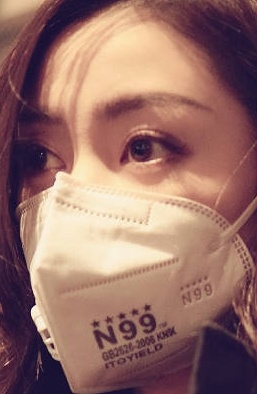

In [7]:
load_img(m_list[0])

#### non-masked dataset의 경로를 n_list에 저장 후 masked dataset의 크기와 같도록 random sampling

In [8]:
names_n = list(sorted(os.listdir("./RMFD/self-built-masked-face-recognition-dataset/AFDB_face_dataset")))

n_path="./RMFD/self-built-masked-face-recognition-dataset/AFDB_face_dataset/"
n_list=[]
for name in names_n:
    files= os.listdir(n_path+name)
    n_list=n_list+[n_path+name+'/'+files[i] for i in range(len(files))]
print("Original length of face dataset:{}".format(len(n_list)))

# sampling
random.seed(777)
sampleidx = random.sample(range(1, len(n_list)), len(m_list))
n_list = [n_list[i] for i in sampleidx]
print("Sampled length of face dataset:{}".format(len(n_list)))

Original length of face dataset:90468
Sampled length of face dataset:2203


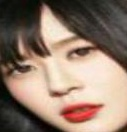

In [9]:
load_img(n_list[0])

In [10]:
img_path = m_list+n_list

In [11]:
m_list

['./RMFD/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset/aidai/0_0_0.jpg',
 './RMFD/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset/aidai/0_0_1.jpg',
 './RMFD/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset/anhu/0_0_5.jpg',
 './RMFD/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset/aoziyi/0_0_툽鬧 2020-02-24 225329.png',
 './RMFD/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset/aoziyi/0_0_툽鬧 2020-02-24 225352.png',
 './RMFD/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset/aoziyi/0_0_툽鬧 2020-02-24 225408.png',
 './RMFD/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset/aoziyi/0_0_툽鬧 2020-02-24 225427.png',
 './RMFD/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset/axin/0_0_0.jpg',
 './RMFD/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset/baijingting/0_0_3.jpg',
 './RMFD/self-built-masked-face-recognition-dataset/AFDB_mask

In [12]:
data=[]
labels=[]

img_size=224
channels=3
n_labels=2

for path in img_path:
    image = load_img(path, target_size=(img_size, img_size))
    image = img_to_array(image)
    image = image/255
    if 'masked_' in path:
        label = 1   # masked image면 label이 1
    else: label = 0 # non-masked image면 label이 0
    
    data.append(image)
    labels.append(label)

In [13]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [14]:
data.shape

(4406, 224, 224, 3)

In [15]:
labels.shape

(4406,)

#### train, test split

In [16]:
train_x, test_x, train_y, test_y = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=777)

In [17]:
# label binary화
lb = LabelBinarizer()
train_y_2d = lb.fit_transform(train_y)
train_y_2d = to_categorical(train_y_2d)

lb = LabelBinarizer()
test_y_2d = lb.fit_transform(test_y)
test_y_2d = to_categorical(test_y_2d)

### Feature extraction 1: densenet

In [58]:
base=DenseNet121(weights='imagenet',include_top=False, input_shape=(224, 224, 3)) 
densenet1=base.output
densenet1=Flatten()(densenet1)
densenet1=Dense(1024, activation="relu", name="dense_feature")(densenet1)
densenet1=Dense(512, activation="relu")(densenet1)
densenet1=Dropout(0.5)(densenet1)
densenet1=Dense(256, activation="relu")(densenet1)
densenet1=Dropout(0.5)(densenet1)
densenet1=Dense(1, activation="sigmoid")(densenet1)
densenet=Model(inputs=base.input, outputs=densenet1)

In [28]:
densenet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

 conv2_block4_0_relu (Activatio  (None, 56, 56, 160)  0          ['conv2_block4_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)       

 ization)                                                                                         
                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_blo

 conv3_block10_concat (Concaten  (None, 28, 28, 448)  0          ['conv3_block9_concat[0][0]',    
 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
          

                                                                                                  
 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block7_0_relu (Activatio  (None, 14, 14, 448)  0          ['conv4_block7_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)

 ate)                                                             'conv4_block15_2_conv[0][0]']   
                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_rel

 ization)                                                                                         
                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_blo

 conv5_block8_concat (Concatena  (None, 7, 7, 768)   0           ['conv5_block7_concat[0][0]',    
 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
          

 on)                                                                                              
                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

                                                                                                  
 dense_4 (Dense)                (None, 256)          131328      ['dropout_2[0][0]']              
                                                                                                  
 dropout_3 (Dropout)            (None, 256)          0           ['dense_4[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 1)            257         ['dropout_3[0][0]']              
                                                                                                  
Total params: 59,075,137
Trainable params: 58,991,489
Non-trainable params: 83,648
__________________________________________________________________________________________________


In [59]:
dense_f=Model(inputs=densenet.input, outputs=densenet.get_layer("dense_feature").output)
dense_f.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_4[0][0]']       
                                )                                                           

 conv2_block4_0_relu (Activatio  (None, 56, 56, 160)  0          ['conv2_block4_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)       

 ization)                                                                                         
                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_blo

 conv3_block10_concat (Concaten  (None, 28, 28, 448)  0          ['conv3_block9_concat[0][0]',    
 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
          

                                                                                                  
 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block7_0_relu (Activatio  (None, 14, 14, 448)  0          ['conv4_block7_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)

 ate)                                                             'conv4_block15_2_conv[0][0]']   
                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_rel

 ization)                                                                                         
                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_blo

 conv5_block8_concat (Concatena  (None, 7, 7, 768)   0           ['conv5_block7_concat[0][0]',    
 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
          

 on)                                                                                              
                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

In [56]:
dense_f.output

<KerasTensor: shape=(None, 1024) dtype=float32 (created by layer 'dense_feature')>

In [60]:
dense_train = dense_f.predict(train_x) 
dense_train = pd.DataFrame(dense_train)

111/111 [==============================] - 190s 2s/step


In [61]:
dense_train

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.000000,1.823433,0.0,2.480142,0.000000,0.000000,2.034155,0.428356,0.106791,0.000000,...,1.029762,1.507499,0.0,0.000000,0.000000,0.0,0.537383,0.000000,0.000000,0.000000
1,0.000000,3.252514,0.0,2.715799,0.000000,0.000000,0.985369,3.571044,3.152846,0.042143,...,1.578925,0.274677,0.0,1.119589,1.977775,0.0,0.000000,1.001081,0.000000,0.000000
2,0.000000,5.283883,0.0,5.491068,0.000000,1.025068,2.460214,1.163384,1.957793,1.168171,...,0.477178,1.324782,0.0,0.000000,0.000000,0.0,1.648343,2.016145,0.000000,0.000000
3,0.000000,1.688538,0.0,2.048834,0.000000,0.586181,0.000000,0.537895,0.000000,0.000000,...,0.515430,0.000000,0.0,0.000000,0.888466,0.0,1.032007,0.000000,0.605292,0.000000
4,0.000000,0.076812,0.0,1.875584,0.000000,0.548536,1.380118,0.000000,0.000000,0.616821,...,1.625938,0.000000,0.0,0.000000,0.000000,0.0,0.449123,0.000000,0.132313,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3519,0.000000,1.190254,0.0,1.100683,0.000000,0.933257,0.131184,0.000000,3.332422,0.180200,...,0.000000,1.959825,0.0,0.000000,0.169130,0.0,0.000000,0.028124,3.386840,0.000000
3520,0.000000,1.269873,0.0,2.039579,0.204692,0.000000,0.985831,0.216884,0.000000,0.722520,...,1.636496,1.592532,0.0,0.000000,0.000000,0.0,0.500727,0.000000,0.000000,0.153167
3521,0.000000,1.243616,0.0,1.315654,0.000000,0.359643,1.403848,0.118306,1.429327,0.000000,...,1.214798,0.000000,0.0,0.000000,0.000000,0.0,0.412103,0.000000,1.268297,0.000000
3522,1.030377,5.108786,0.0,2.225019,0.000000,0.392849,0.577058,0.000000,1.982258,0.000000,...,2.628549,0.549355,0.0,0.000000,0.000000,0.0,1.702579,0.658538,0.062693,0.000000


In [62]:
dense_test=dense_f.predict(test_x)
dense_test=pd.DataFrame(dense_test)

28/28 [==============================] - 49s 2s/step


In [63]:
dense_test

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.000000,3.423364,0.000000,4.165003,0.263613,0.000000,0.737016,0.000000,0.045327,0.000000,...,1.171303,0.000000,0.0,0.000000,0.704579,0.000000,0.385490,0.398062,0.000000,0.000000
1,0.053131,0.809556,0.000000,1.361802,0.000000,0.000000,0.615414,0.114028,0.000000,0.039194,...,1.370874,0.055299,0.0,0.000000,0.989829,0.000000,0.467742,0.000000,0.373946,0.545925
2,0.544731,6.167234,0.000000,2.456257,0.000000,0.000000,0.000000,2.459340,0.515896,0.000000,...,0.102828,0.779612,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,2.539781,0.655938,3.757725,0.000000,0.000000,0.000000,0.711466,0.000000,0.000000,...,0.042892,1.499475,0.0,0.000000,0.113546,1.166997,0.000000,0.110572,0.919736,0.225944
4,0.000000,1.423239,0.000000,1.821106,0.000000,0.000000,0.000000,0.268938,1.867390,0.520784,...,0.000000,0.000000,0.0,0.000000,0.000000,0.061779,1.337804,0.830069,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,0.172099,4.962748,0.000000,2.536330,0.000000,0.735305,0.092646,0.464136,2.945385,1.398569,...,1.375833,0.887359,0.0,1.533623,0.000000,1.543604,0.000000,1.841130,0.000000,0.000000
878,0.000000,1.365267,0.000000,3.010481,0.000000,0.380731,2.115509,1.963438,2.800199,0.000000,...,1.400390,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.198285,0.000000
879,0.000000,1.622045,0.000000,0.000000,0.000000,0.189273,0.000000,0.409903,0.000000,0.000000,...,0.107373,0.828603,0.0,0.000000,0.346473,0.000000,0.000000,0.000000,0.000000,0.042932
880,0.000000,1.087661,0.000000,1.467826,0.000000,1.483263,1.204797,0.000000,1.201695,0.743981,...,0.604977,1.085972,0.0,0.000000,0.000000,0.000000,0.974953,0.000000,0.329650,0.000000


#### classification 1: densenet을 통한 분류

In [30]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 15,
    horizontal_flip = False,
    zoom_range = 0.20)

In [34]:
densenet.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(),metrics=['accuracy'])
datagen.fit(train_x)

history = densenet.fit_generator(datagen.flow(train_x, train_y, batch_size=32),
                              epochs = 5,
                              shuffle=True,
                              verbose = 1,
                              steps_per_epoch=train_x.shape[0] // 32)

<ipython-input-34-874e1317fb0d>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = densenet.fit_generator(datagen.flow(train_x, train_y, batch_size=32),


Epoch 1/5
110/110 [==============================] - 1138s 10s/step - loss: 0.4977 - accuracy: 0.9149
Epoch 2/5
110/110 [==============================] - 1105s 10s/step - loss: 0.4627 - accuracy: 0.9467
Epoch 3/5
110/110 [==============================] - 1140s 10s/step - loss: 0.3533 - accuracy: 0.9084
Epoch 4/5
110/110 [==============================] - 1123s 10s/step - loss: 1.4855 - accuracy: 0.7520
Epoch 5/5
110/110 [==============================] - 1113s 10s/step - loss: 0.3278 - accuracy: 0.8852


In [46]:
pred_dense=densenet.predict(test_x)
pred_dense1=[1 if pred_dense[i][0]>=0.5 else 0 for i in range(len(pred_dense))]
print(accuracy_score(test_y, pred_dense1))
print(confusion_matrix(test_y, pred_dense1))

0.8594104308390023
[[433   8]
 [116 325]]


#### classification 2: densenet - xgboost

In [64]:
dense_xgb = XGBClassifier(random_state=777, eval_metric='logloss',
                         n_estimators=1000, learning_rate=0.05)
dense_xgb.fit(dense_train, train_y)

C:\Users\YJ-HWANG\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=12,
              num_parallel_tree=1, random_state=777, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [65]:
pred_dense_xgb=dense_xgb.predict(dense_test)
print(accuracy_score(test_y, pred_dense_xgb))
print(confusion_matrix(test_y, pred_dense_xgb))

0.9931972789115646
[[438   3]
 [  3 438]]


#### classification 3: densenet - lightgbm

In [66]:
dense_lgbm = LGBMClassifier(random_state=777, learning_rate=0.05, n_estimators=1000)
dense_lgbm.fit(dense_train, train_y)

LGBMClassifier(learning_rate=0.05, n_estimators=1000, random_state=777)

In [67]:
pred_dense_lgbm=dense_lgbm.predict(dense_test)
print(accuracy_score(test_y, pred_dense_lgbm))
print(confusion_matrix(test_y, pred_dense_lgbm))

0.9920634920634921
[[438   3]
 [  4 437]]


#### stacking
3개 중 2개 이상의 모델이 1로 예측했으면 1, 아니면 0으로 최종 예측

In [69]:
dense_preds = [1 if pred_dense1[i]+pred_dense_xgb[i]+pred_dense_lgbm[i] >= 2 else 0 for i in range(len(pred_dense1))]
print(accuracy_score(test_y, dense_preds))
print(confusion_matrix(test_y, dense_preds))

0.9931972789115646
[[438   3]
 [  3 438]]


### Feature extraction 2: MobileNetV2

In [72]:
base=MobileNetV2(weights='imagenet',include_top=False, input_shape=(224, 224, 3)) 
mobile1=base.output
mobile1=Flatten()(mobile1)
mobile1=Dense(1024, activation="relu", name="mobile_feature")(mobile1)
mobile=Dense(512, activation="relu")(mobile1)
mobile1=Dropout(0.5)(mobile1)
mobile1=Dense(256, activation="relu")(mobile1)
mobile1=Dropout(0.5)(mobile1)
mobile1=Dense(1, activation="sigmoid")(mobile1)
mobile=Model(inputs=base.input, outputs=mobile1)

In [73]:
mobile.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [116]:
mobile_f=Model(inputs=mobile.input, outputs=mobile.get_layer("mobile_feature").output)
mobile_f.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                          

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [75]:
mobile_train = mobile_f.predict(train_x) 
mobile_train = pd.DataFrame(mobile_train)

111/111 [==============================] - 55s 488ms/step


In [100]:
mobile_train

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.0,0.907088,0.280883,3.083403,2.516260,0.255575,0.000000,0.311272,0.863786,0.000000,...,0.000000,3.018462,1.345976,2.328701,0.000000,0.974689,2.616584,1.052013,0.000000,0.000000
1,0.0,0.819653,1.410941,0.000000,1.863344,1.295151,0.000000,1.245921,2.914926,1.695435,...,0.000000,0.000000,0.000000,0.900205,1.157497,0.417859,0.000000,0.000000,0.828682,3.240713
2,0.0,0.000000,0.000000,0.000000,0.848707,0.000000,0.000000,1.928535,0.234053,0.000000,...,0.000000,0.000000,1.949678,2.868365,0.000000,0.523990,0.000000,0.000000,1.742027,0.000000
3,0.0,1.432352,0.000000,0.192523,3.789197,1.607905,0.000000,0.010089,0.000000,0.338824,...,1.039924,0.000000,2.153147,0.843875,0.000000,0.865211,1.211767,0.327407,0.000000,0.000000
4,0.0,1.410510,0.000000,1.081114,2.329050,1.203054,0.000000,0.000000,0.000000,0.654428,...,0.163992,0.000000,1.833678,0.000000,0.000000,0.000000,0.175628,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3519,0.0,0.000000,0.369547,0.628190,1.790913,0.274203,0.000000,0.999841,0.284345,1.482796,...,0.000000,0.000000,1.289881,2.118574,0.357109,0.623851,0.000000,1.070183,0.000000,0.000000
3520,0.0,0.000000,0.864507,0.887547,3.592206,0.792074,0.000000,1.122482,0.336942,0.000000,...,0.000000,0.000000,0.035927,0.941612,0.000000,0.866222,2.319025,0.000000,0.400597,0.000000
3521,0.0,0.321680,0.000000,0.000000,1.016664,0.777663,2.061177,1.807221,2.031455,3.962025,...,0.000000,0.000000,0.039952,0.000000,0.000000,3.210623,0.000000,4.843270,0.000000,0.681427
3522,0.0,0.189713,1.473197,0.851932,0.000000,0.000000,0.000000,0.143275,0.737497,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.548162,0.000000,1.572255,0.000000,2.511273


In [77]:
mobile_test=mobile_f.predict(test_x)
mobile_test=pd.DataFrame(mobile_test)
mobile_test

28/28 [==============================] - 14s 493ms/step


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.0,0.000000,0.071396,0.017695,3.673881,0.471343,0.0,0.000000,3.589512,0.716392,...,0.000000,0.000000,0.893443,0.565942,0.000000,1.088546,2.267860,0.000000,0.000000,1.197202
1,0.0,1.198966,0.000000,0.550435,2.351392,1.380474,0.0,0.643388,0.184286,0.000000,...,0.000000,1.585001,1.887091,1.000464,0.000000,0.000000,0.000000,0.649841,0.000000,0.000000
2,0.0,1.530438,1.143170,0.710333,0.000000,1.008752,0.0,0.000000,0.849497,1.551340,...,0.491495,0.000000,0.034490,0.952331,0.683649,0.000000,0.000000,0.666234,1.047228,2.665774
3,0.0,1.387380,0.000000,0.245153,1.285305,0.847461,0.0,0.000000,0.660612,0.000000,...,0.000000,0.000000,2.860075,1.562763,1.207911,1.143420,0.523071,0.000000,0.000000,0.894169
4,0.0,0.000000,1.846251,0.614083,0.000000,0.000000,0.0,0.000000,2.050787,1.508875,...,0.000000,0.000000,1.829811,0.963416,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,0.0,0.000000,1.289460,0.444606,1.217648,0.000000,0.0,0.000000,3.528797,0.319326,...,0.851765,0.000000,1.638698,0.674423,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
878,0.0,2.570684,0.725743,2.108425,3.485122,0.000000,0.0,0.000000,1.509512,0.364090,...,0.000000,0.000000,1.423768,0.000000,0.000000,1.863267,1.065236,0.443626,0.000000,0.000000
879,0.0,2.225444,1.751565,2.984794,0.448398,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.720093,0.000000,0.000000,0.070911,1.227422,0.585271,1.590830,0.000000
880,0.0,1.999833,1.762823,1.494997,1.673322,0.420309,0.0,0.000000,0.000000,0.000000,...,1.299507,0.229166,0.536008,0.905816,0.000000,0.217310,1.659516,0.000000,0.000000,0.000000


#### classification 1: mobilenet을 이용한 분류

In [117]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 15,
    horizontal_flip = False,
    zoom_range = 0.20)

In [118]:
mobile.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(),metrics=['accuracy'])
datagen.fit(train_x)

history = mobile.fit_generator(datagen.flow(train_x, train_y, batch_size=32),
                              epochs = 5,
                              shuffle=True,
                              verbose = 1,
                              steps_per_epoch=train_x.shape[0] // 32)

<ipython-input-118-d3b65a44f910>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = mobile.fit_generator(datagen.flow(train_x, train_y, batch_size=32),


Epoch 1/5
110/110 [==============================] - 337s 3s/step - loss: 0.1156 - accuracy: 0.9788
Epoch 2/5
110/110 [==============================] - 332s 3s/step - loss: 0.8851 - accuracy: 0.9487
Epoch 3/5
110/110 [==============================] - 330s 3s/step - loss: 0.1359 - accuracy: 0.9608
Epoch 4/5
110/110 [==============================] - 332s 3s/step - loss: 0.0877 - accuracy: 0.9759
Epoch 5/5
110/110 [==============================] - 331s 3s/step - loss: 0.0565 - accuracy: 0.9805


In [119]:
pred_mobile=mobile.predict(test_x)

28/28 [==============================] - 16s 548ms/step


In [120]:
pred_mobile

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [121]:
pred_mobile1=[1 if pred_mobile[i][0]>=0.5 else 0 for i in range(len(pred_mobile))]
print(accuracy_score(test_y, pred_mobile1))
print(confusion_matrix(test_y, pred_mobile1))

0.5
[[  0 441]
 [  0 441]]


#### classification 2: mobilenetv2 - xgboost

In [105]:
mobile_xgb = XGBClassifier(random_state=777, eval_metric='logloss',
                          learning_rate=0.08, n_estimators=1000)
mobile_xgb.fit(mobile_train, train_y)

C:\Users\YJ-HWANG\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.08, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=12,
              num_parallel_tree=1, random_state=777, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [106]:
pred_mobile_xgb=mobile_xgb.predict(mobile_test)
print(accuracy_score(test_y, pred_mobile_xgb))
print(confusion_matrix(test_y, pred_mobile_xgb))

0.9841269841269841
[[434   7]
 [  7 434]]


#### classification 3: mobilenetv2 - lightgbm

In [107]:
mobile_lgbm = LGBMClassifier(random_state=777,
                            learning_rate=0.05, n_estimators=1000)
mobile_lgbm.fit(mobile_train, train_y)

LGBMClassifier(learning_rate=0.05, n_estimators=1000, random_state=777)

In [108]:
pred_mobile_lgbm=mobile_lgbm.predict(mobile_test)
print(accuracy_score(test_y, pred_mobile_lgbm))
print(confusion_matrix(test_y, pred_mobile_lgbm))

0.9852607709750567
[[435   6]
 [  7 434]]


#### stacking
3개 중 2개 이상의 모델이 1로 예측했으면 1, 아니면 0으로 최종 예측

In [122]:
mobile_preds = [1 if pred_mobile1[i]+pred_mobile_xgb[i]+pred_mobile_lgbm[i] >= 2 else 0 for i in range(len(pred_mobile1))]
print(accuracy_score(test_y, mobile_preds))
print(confusion_matrix(test_y, mobile_preds))

0.9852607709750567
[[434   7]
 [  6 435]]


### Feature extraction 3: EfficientNetV2

In [81]:
base=EfficientNetV2L(weights='imagenet',include_top=False, input_shape=(224, 224, 3)) 
eff1=base.output
eff1=Flatten()(eff1)
eff1=Dense(1024, activation="relu", name="eff_feature")(eff1)
eff=Dense(512, activation="relu")(eff1)
eff1=Dropout(0.5)(eff1)
eff1=Dense(256, activation="relu")(eff1)
eff1=Dropout(0.5)(eff1)
eff1=Dense(1, activation="sigmoid")(eff1)
eff=Model(inputs=base.input, outputs=eff1)

In [82]:
eff.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_5[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['rescaling[0][0]']              
                                )                                                                 
                                                                                            

 block2a_project_conv (Conv2D)  (None, 56, 56, 64)   8192        ['block2a_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 64)  256         ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 256)  147456      ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 256)  1024       ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block2f_expand_bn (BatchNormal  (None, 56, 56, 256)  1024       ['block2f_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2f_expand_activation (Act  (None, 56, 56, 256)  0          ['block2f_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2f_project_conv (Conv2D)  (None, 56, 56, 64)   16384       ['block2f_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block2f_p

                                                                                                  
 block3c_drop (Dropout)         (None, 28, 28, 96)   0           ['block3c_project_bn[0][0]']     
                                                                                                  
 block3c_add (Add)              (None, 28, 28, 96)   0           ['block3c_drop[0][0]',           
                                                                  'block3b_add[0][0]']            
                                                                                                  
 block3d_expand_conv (Conv2D)   (None, 28, 28, 384)  331776      ['block3c_add[0][0]']            
                                                                                                  
 block3d_expand_bn (BatchNormal  (None, 28, 28, 384)  1536       ['block3d_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block4a_expand_bn (BatchNormal  (None, 28, 28, 384)  1536       ['block4a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4a_expand_activation (Act  (None, 28, 28, 384)  0          ['block4a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4a_dwconv2 (DepthwiseConv  (None, 14, 14, 384)  3456       ['block4a_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block4a_b

 block4c_bn (BatchNormalization  (None, 14, 14, 768)  3072       ['block4c_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block4c_activation (Activation  (None, 14, 14, 768)  0          ['block4c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4c_se_squeeze (GlobalAver  (None, 768)         0           ['block4c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4c_se_reshape (Reshape)   (None, 1, 1, 768)    0           ['block4c_se_squeeze[0][0]']     
          

                                                                                                  
 block4e_se_squeeze (GlobalAver  (None, 768)         0           ['block4e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4e_se_reshape (Reshape)   (None, 1, 1, 768)    0           ['block4e_se_squeeze[0][0]']     
                                                                                                  
 block4e_se_reduce (Conv2D)     (None, 1, 1, 48)     36912       ['block4e_se_reshape[0][0]']     
                                                                                                  
 block4e_se_expand (Conv2D)     (None, 1, 1, 768)    37632       ['block4e_se_reduce[0][0]']      
                                                                                                  
 block4e_s

                                                                                                  
 block4g_se_reduce (Conv2D)     (None, 1, 1, 48)     36912       ['block4g_se_reshape[0][0]']     
                                                                                                  
 block4g_se_expand (Conv2D)     (None, 1, 1, 768)    37632       ['block4g_se_reduce[0][0]']      
                                                                                                  
 block4g_se_excite (Multiply)   (None, 14, 14, 768)  0           ['block4g_activation[0][0]',     
                                                                  'block4g_se_expand[0][0]']      
                                                                                                  
 block4g_project_conv (Conv2D)  (None, 14, 14, 192)  147456      ['block4g_se_excite[0][0]']      
                                                                                                  
 block4g_p

 block4i_se_excite (Multiply)   (None, 14, 14, 768)  0           ['block4i_activation[0][0]',     
                                                                  'block4i_se_expand[0][0]']      
                                                                                                  
 block4i_project_conv (Conv2D)  (None, 14, 14, 192)  147456      ['block4i_se_excite[0][0]']      
                                                                                                  
 block4i_project_bn (BatchNorma  (None, 14, 14, 192)  768        ['block4i_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4i_drop (Dropout)         (None, 14, 14, 192)  0           ['block4i_project_bn[0][0]']     
                                                                                                  
 block4i_a

                                                                                                  
 block5a_project_bn (BatchNorma  (None, 14, 14, 224)  896        ['block5a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, 14, 14, 1344  301056      ['block5a_project_bn[0][0]']     
                                )                                                                 
                                                                                                  
 block5b_expand_bn (BatchNormal  (None, 14, 14, 1344  5376       ['block5b_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block5b_e

                                                                                                  
 block5d_expand_conv (Conv2D)   (None, 14, 14, 1344  301056      ['block5c_add[0][0]']            
                                )                                                                 
                                                                                                  
 block5d_expand_bn (BatchNormal  (None, 14, 14, 1344  5376       ['block5d_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block5d_expand_activation (Act  (None, 14, 14, 1344  0          ['block5d_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block5d_d

                                                                                                  
 block5f_expand_bn (BatchNormal  (None, 14, 14, 1344  5376       ['block5f_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block5f_expand_activation (Act  (None, 14, 14, 1344  0          ['block5f_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block5f_dwconv2 (DepthwiseConv  (None, 14, 14, 1344  12096      ['block5f_expand_activation[0][0]
 2D)                            )                                ']                               
                                                                                                  
 block5f_b

                                                                                                  
 block5h_expand_activation (Act  (None, 14, 14, 1344  0          ['block5h_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block5h_dwconv2 (DepthwiseConv  (None, 14, 14, 1344  12096      ['block5h_expand_activation[0][0]
 2D)                            )                                ']                               
                                                                                                  
 block5h_bn (BatchNormalization  (None, 14, 14, 1344  5376       ['block5h_dwconv2[0][0]']        
 )                              )                                                                 
                                                                                                  
 block5h_a

                                                                                                  
 block5j_dwconv2 (DepthwiseConv  (None, 14, 14, 1344  12096      ['block5j_expand_activation[0][0]
 2D)                            )                                ']                               
                                                                                                  
 block5j_bn (BatchNormalization  (None, 14, 14, 1344  5376       ['block5j_dwconv2[0][0]']        
 )                              )                                                                 
                                                                                                  
 block5j_activation (Activation  (None, 14, 14, 1344  0          ['block5j_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5j_s

                                                                                                  
 block5l_bn (BatchNormalization  (None, 14, 14, 1344  5376       ['block5l_dwconv2[0][0]']        
 )                              )                                                                 
                                                                                                  
 block5l_activation (Activation  (None, 14, 14, 1344  0          ['block5l_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5l_se_squeeze (GlobalAver  (None, 1344)        0           ['block5l_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5l_s

                                                                                                  
 block5n_activation (Activation  (None, 14, 14, 1344  0          ['block5n_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5n_se_squeeze (GlobalAver  (None, 1344)        0           ['block5n_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5n_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5n_se_squeeze[0][0]']     
                                                                                                  
 block5n_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5n_se_reshape[0][0]']     
          

                                                                                                  
 block5p_se_squeeze (GlobalAver  (None, 1344)        0           ['block5p_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5p_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5p_se_squeeze[0][0]']     
                                                                                                  
 block5p_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5p_se_reshape[0][0]']     
                                                                                                  
 block5p_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5p_se_reduce[0][0]']      
                                                                                                  
 block5p_s

                                                                                                  
 block5r_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5r_se_squeeze[0][0]']     
                                                                                                  
 block5r_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5r_se_reshape[0][0]']     
                                                                                                  
 block5r_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5r_se_reduce[0][0]']      
                                                                                                  
 block5r_se_excite (Multiply)   (None, 14, 14, 1344  0           ['block5r_activation[0][0]',     
                                )                                 'block5r_se_expand[0][0]']      
                                                                                                  
 block5r_p

 block6a_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block6a_se_reshape[0][0]']     
                                                                                                  
 block6a_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block6a_se_reduce[0][0]']      
                                                                                                  
 block6a_se_excite (Multiply)   (None, 7, 7, 1344)   0           ['block6a_activation[0][0]',     
                                                                  'block6a_se_expand[0][0]']      
                                                                                                  
 block6a_project_conv (Conv2D)  (None, 7, 7, 384)    516096      ['block6a_se_excite[0][0]']      
                                                                                                  
 block6a_project_bn (BatchNorma  (None, 7, 7, 384)   1536        ['block6a_project_conv[0][0]']   
 lization)

 lization)                                                                                        
                                                                                                  
 block6c_drop (Dropout)         (None, 7, 7, 384)    0           ['block6c_project_bn[0][0]']     
                                                                                                  
 block6c_add (Add)              (None, 7, 7, 384)    0           ['block6c_drop[0][0]',           
                                                                  'block6b_add[0][0]']            
                                                                                                  
 block6d_expand_conv (Conv2D)   (None, 7, 7, 2304)   884736      ['block6c_add[0][0]']            
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, 7, 7, 2304)  9216        ['block6d_expand_conv[0][0]']    
 ization) 

                                                                  'block6d_add[0][0]']            
                                                                                                  
 block6f_expand_conv (Conv2D)   (None, 7, 7, 2304)   884736      ['block6e_add[0][0]']            
                                                                                                  
 block6f_expand_bn (BatchNormal  (None, 7, 7, 2304)  9216        ['block6f_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6f_expand_activation (Act  (None, 7, 7, 2304)  0           ['block6f_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6f_d

 ization)                                                                                         
                                                                                                  
 block6h_expand_activation (Act  (None, 7, 7, 2304)  0           ['block6h_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6h_dwconv2 (DepthwiseConv  (None, 7, 7, 2304)  20736       ['block6h_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6h_bn (BatchNormalization  (None, 7, 7, 2304)  9216        ['block6h_dwconv2[0][0]']        
 )                                                                                                
          

 block6j_dwconv2 (DepthwiseConv  (None, 7, 7, 2304)  20736       ['block6j_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6j_bn (BatchNormalization  (None, 7, 7, 2304)  9216        ['block6j_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6j_activation (Activation  (None, 7, 7, 2304)  0           ['block6j_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6j_se_squeeze (GlobalAver  (None, 2304)        0           ['block6j_activation[0][0]']     
 agePoolin

                                                                                                  
 block6l_activation (Activation  (None, 7, 7, 2304)  0           ['block6l_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6l_se_squeeze (GlobalAver  (None, 2304)        0           ['block6l_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6l_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6l_se_squeeze[0][0]']     
                                                                                                  
 block6l_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6l_se_reshape[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block6n_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6n_se_squeeze[0][0]']     
                                                                                                  
 block6n_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6n_se_reshape[0][0]']     
                                                                                                  
 block6n_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6n_se_reduce[0][0]']      
                                                                                                  
 block6n_se_excite (Multiply)   (None, 7, 7, 2304)   0           ['block6n_activation[0][0]',     
                                                                  'block6n_se_expand[0][0]']      
          

                                                                                                  
 block6p_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6p_se_reduce[0][0]']      
                                                                                                  
 block6p_se_excite (Multiply)   (None, 7, 7, 2304)   0           ['block6p_activation[0][0]',     
                                                                  'block6p_se_expand[0][0]']      
                                                                                                  
 block6p_project_conv (Conv2D)  (None, 7, 7, 384)    884736      ['block6p_se_excite[0][0]']      
                                                                                                  
 block6p_project_bn (BatchNorma  (None, 7, 7, 384)   1536        ['block6p_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block6r_project_conv (Conv2D)  (None, 7, 7, 384)    884736      ['block6r_se_excite[0][0]']      
                                                                                                  
 block6r_project_bn (BatchNorma  (None, 7, 7, 384)   1536        ['block6r_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6r_drop (Dropout)         (None, 7, 7, 384)    0           ['block6r_project_bn[0][0]']     
                                                                                                  
 block6r_add (Add)              (None, 7, 7, 384)    0           ['block6r_drop[0][0]',           
                                                                  'block6q_add[0][0]']            
          

                                                                                                  
 block6t_drop (Dropout)         (None, 7, 7, 384)    0           ['block6t_project_bn[0][0]']     
                                                                                                  
 block6t_add (Add)              (None, 7, 7, 384)    0           ['block6t_drop[0][0]',           
                                                                  'block6s_add[0][0]']            
                                                                                                  
 block6u_expand_conv (Conv2D)   (None, 7, 7, 2304)   884736      ['block6t_add[0][0]']            
                                                                                                  
 block6u_expand_bn (BatchNormal  (None, 7, 7, 2304)  9216        ['block6u_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block6w_expand_conv (Conv2D)   (None, 7, 7, 2304)   884736      ['block6v_add[0][0]']            
                                                                                                  
 block6w_expand_bn (BatchNormal  (None, 7, 7, 2304)  9216        ['block6w_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6w_expand_activation (Act  (None, 7, 7, 2304)  0           ['block6w_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6w_dwconv2 (DepthwiseConv  (None, 7, 7, 2304)  20736       ['block6w_expand_activation[0][0]
 2D)      

                                                                                                  
 block6y_expand_activation (Act  (None, 7, 7, 2304)  0           ['block6y_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6y_dwconv2 (DepthwiseConv  (None, 7, 7, 2304)  20736       ['block6y_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6y_bn (BatchNormalization  (None, 7, 7, 2304)  9216        ['block6y_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6y_a

 block7b_activation (Activation  (None, 7, 7, 3840)  0           ['block7b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block7b_se_squeeze (GlobalAver  (None, 3840)        0           ['block7b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7b_se_reshape (Reshape)   (None, 1, 1, 3840)   0           ['block7b_se_squeeze[0][0]']     
                                                                                                  
 block7b_se_reduce (Conv2D)     (None, 1, 1, 160)    614560      ['block7b_se_reshape[0][0]']     
                                                                                                  
 block7b_s

                                                                                                  
 block7d_se_reshape (Reshape)   (None, 1, 1, 3840)   0           ['block7d_se_squeeze[0][0]']     
                                                                                                  
 block7d_se_reduce (Conv2D)     (None, 1, 1, 160)    614560      ['block7d_se_reshape[0][0]']     
                                                                                                  
 block7d_se_expand (Conv2D)     (None, 1, 1, 3840)   618240      ['block7d_se_reduce[0][0]']      
                                                                                                  
 block7d_se_excite (Multiply)   (None, 7, 7, 3840)   0           ['block7d_activation[0][0]',     
                                                                  'block7d_se_expand[0][0]']      
                                                                                                  
 block7d_p

 block7f_se_expand (Conv2D)     (None, 1, 1, 3840)   618240      ['block7f_se_reduce[0][0]']      
                                                                                                  
 block7f_se_excite (Multiply)   (None, 7, 7, 3840)   0           ['block7f_activation[0][0]',     
                                                                  'block7f_se_expand[0][0]']      
                                                                                                  
 block7f_project_conv (Conv2D)  (None, 7, 7, 640)    2457600     ['block7f_se_excite[0][0]']      
                                                                                                  
 block7f_project_bn (BatchNorma  (None, 7, 7, 640)   2560        ['block7f_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block7f_d

In [83]:
eff_f=Model(inputs=eff.input, outputs=eff.get_layer("eff_feature").output)
eff_f.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_5[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['rescaling[0][0]']              
                                )                                                                 
                                                                                           

 block2a_project_conv (Conv2D)  (None, 56, 56, 64)   8192        ['block2a_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 64)  256         ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 256)  147456      ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 256)  1024       ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block2f_expand_bn (BatchNormal  (None, 56, 56, 256)  1024       ['block2f_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2f_expand_activation (Act  (None, 56, 56, 256)  0          ['block2f_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2f_project_conv (Conv2D)  (None, 56, 56, 64)   16384       ['block2f_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block2f_p

                                                                                                  
 block3c_drop (Dropout)         (None, 28, 28, 96)   0           ['block3c_project_bn[0][0]']     
                                                                                                  
 block3c_add (Add)              (None, 28, 28, 96)   0           ['block3c_drop[0][0]',           
                                                                  'block3b_add[0][0]']            
                                                                                                  
 block3d_expand_conv (Conv2D)   (None, 28, 28, 384)  331776      ['block3c_add[0][0]']            
                                                                                                  
 block3d_expand_bn (BatchNormal  (None, 28, 28, 384)  1536       ['block3d_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block4a_expand_bn (BatchNormal  (None, 28, 28, 384)  1536       ['block4a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4a_expand_activation (Act  (None, 28, 28, 384)  0          ['block4a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4a_dwconv2 (DepthwiseConv  (None, 14, 14, 384)  3456       ['block4a_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block4a_b

 block4c_bn (BatchNormalization  (None, 14, 14, 768)  3072       ['block4c_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block4c_activation (Activation  (None, 14, 14, 768)  0          ['block4c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4c_se_squeeze (GlobalAver  (None, 768)         0           ['block4c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4c_se_reshape (Reshape)   (None, 1, 1, 768)    0           ['block4c_se_squeeze[0][0]']     
          

                                                                                                  
 block4e_se_squeeze (GlobalAver  (None, 768)         0           ['block4e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4e_se_reshape (Reshape)   (None, 1, 1, 768)    0           ['block4e_se_squeeze[0][0]']     
                                                                                                  
 block4e_se_reduce (Conv2D)     (None, 1, 1, 48)     36912       ['block4e_se_reshape[0][0]']     
                                                                                                  
 block4e_se_expand (Conv2D)     (None, 1, 1, 768)    37632       ['block4e_se_reduce[0][0]']      
                                                                                                  
 block4e_s

                                                                                                  
 block4g_se_reduce (Conv2D)     (None, 1, 1, 48)     36912       ['block4g_se_reshape[0][0]']     
                                                                                                  
 block4g_se_expand (Conv2D)     (None, 1, 1, 768)    37632       ['block4g_se_reduce[0][0]']      
                                                                                                  
 block4g_se_excite (Multiply)   (None, 14, 14, 768)  0           ['block4g_activation[0][0]',     
                                                                  'block4g_se_expand[0][0]']      
                                                                                                  
 block4g_project_conv (Conv2D)  (None, 14, 14, 192)  147456      ['block4g_se_excite[0][0]']      
                                                                                                  
 block4g_p

 block4i_se_excite (Multiply)   (None, 14, 14, 768)  0           ['block4i_activation[0][0]',     
                                                                  'block4i_se_expand[0][0]']      
                                                                                                  
 block4i_project_conv (Conv2D)  (None, 14, 14, 192)  147456      ['block4i_se_excite[0][0]']      
                                                                                                  
 block4i_project_bn (BatchNorma  (None, 14, 14, 192)  768        ['block4i_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4i_drop (Dropout)         (None, 14, 14, 192)  0           ['block4i_project_bn[0][0]']     
                                                                                                  
 block4i_a

                                                                                                  
 block5a_project_bn (BatchNorma  (None, 14, 14, 224)  896        ['block5a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, 14, 14, 1344  301056      ['block5a_project_bn[0][0]']     
                                )                                                                 
                                                                                                  
 block5b_expand_bn (BatchNormal  (None, 14, 14, 1344  5376       ['block5b_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block5b_e

                                                                                                  
 block5d_expand_conv (Conv2D)   (None, 14, 14, 1344  301056      ['block5c_add[0][0]']            
                                )                                                                 
                                                                                                  
 block5d_expand_bn (BatchNormal  (None, 14, 14, 1344  5376       ['block5d_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block5d_expand_activation (Act  (None, 14, 14, 1344  0          ['block5d_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block5d_d

                                                                                                  
 block5f_expand_bn (BatchNormal  (None, 14, 14, 1344  5376       ['block5f_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block5f_expand_activation (Act  (None, 14, 14, 1344  0          ['block5f_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block5f_dwconv2 (DepthwiseConv  (None, 14, 14, 1344  12096      ['block5f_expand_activation[0][0]
 2D)                            )                                ']                               
                                                                                                  
 block5f_b

                                                                                                  
 block5h_expand_activation (Act  (None, 14, 14, 1344  0          ['block5h_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block5h_dwconv2 (DepthwiseConv  (None, 14, 14, 1344  12096      ['block5h_expand_activation[0][0]
 2D)                            )                                ']                               
                                                                                                  
 block5h_bn (BatchNormalization  (None, 14, 14, 1344  5376       ['block5h_dwconv2[0][0]']        
 )                              )                                                                 
                                                                                                  
 block5h_a

                                                                                                  
 block5j_dwconv2 (DepthwiseConv  (None, 14, 14, 1344  12096      ['block5j_expand_activation[0][0]
 2D)                            )                                ']                               
                                                                                                  
 block5j_bn (BatchNormalization  (None, 14, 14, 1344  5376       ['block5j_dwconv2[0][0]']        
 )                              )                                                                 
                                                                                                  
 block5j_activation (Activation  (None, 14, 14, 1344  0          ['block5j_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5j_s

                                                                                                  
 block5l_bn (BatchNormalization  (None, 14, 14, 1344  5376       ['block5l_dwconv2[0][0]']        
 )                              )                                                                 
                                                                                                  
 block5l_activation (Activation  (None, 14, 14, 1344  0          ['block5l_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5l_se_squeeze (GlobalAver  (None, 1344)        0           ['block5l_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5l_s

                                                                                                  
 block5n_activation (Activation  (None, 14, 14, 1344  0          ['block5n_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5n_se_squeeze (GlobalAver  (None, 1344)        0           ['block5n_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5n_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5n_se_squeeze[0][0]']     
                                                                                                  
 block5n_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5n_se_reshape[0][0]']     
          

                                                                                                  
 block5p_se_squeeze (GlobalAver  (None, 1344)        0           ['block5p_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5p_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5p_se_squeeze[0][0]']     
                                                                                                  
 block5p_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5p_se_reshape[0][0]']     
                                                                                                  
 block5p_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5p_se_reduce[0][0]']      
                                                                                                  
 block5p_s

                                                                                                  
 block5r_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5r_se_squeeze[0][0]']     
                                                                                                  
 block5r_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5r_se_reshape[0][0]']     
                                                                                                  
 block5r_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5r_se_reduce[0][0]']      
                                                                                                  
 block5r_se_excite (Multiply)   (None, 14, 14, 1344  0           ['block5r_activation[0][0]',     
                                )                                 'block5r_se_expand[0][0]']      
                                                                                                  
 block5r_p

 block6a_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block6a_se_reshape[0][0]']     
                                                                                                  
 block6a_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block6a_se_reduce[0][0]']      
                                                                                                  
 block6a_se_excite (Multiply)   (None, 7, 7, 1344)   0           ['block6a_activation[0][0]',     
                                                                  'block6a_se_expand[0][0]']      
                                                                                                  
 block6a_project_conv (Conv2D)  (None, 7, 7, 384)    516096      ['block6a_se_excite[0][0]']      
                                                                                                  
 block6a_project_bn (BatchNorma  (None, 7, 7, 384)   1536        ['block6a_project_conv[0][0]']   
 lization)

 lization)                                                                                        
                                                                                                  
 block6c_drop (Dropout)         (None, 7, 7, 384)    0           ['block6c_project_bn[0][0]']     
                                                                                                  
 block6c_add (Add)              (None, 7, 7, 384)    0           ['block6c_drop[0][0]',           
                                                                  'block6b_add[0][0]']            
                                                                                                  
 block6d_expand_conv (Conv2D)   (None, 7, 7, 2304)   884736      ['block6c_add[0][0]']            
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, 7, 7, 2304)  9216        ['block6d_expand_conv[0][0]']    
 ization) 

                                                                  'block6d_add[0][0]']            
                                                                                                  
 block6f_expand_conv (Conv2D)   (None, 7, 7, 2304)   884736      ['block6e_add[0][0]']            
                                                                                                  
 block6f_expand_bn (BatchNormal  (None, 7, 7, 2304)  9216        ['block6f_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6f_expand_activation (Act  (None, 7, 7, 2304)  0           ['block6f_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6f_d

 ization)                                                                                         
                                                                                                  
 block6h_expand_activation (Act  (None, 7, 7, 2304)  0           ['block6h_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6h_dwconv2 (DepthwiseConv  (None, 7, 7, 2304)  20736       ['block6h_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6h_bn (BatchNormalization  (None, 7, 7, 2304)  9216        ['block6h_dwconv2[0][0]']        
 )                                                                                                
          

 block6j_dwconv2 (DepthwiseConv  (None, 7, 7, 2304)  20736       ['block6j_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6j_bn (BatchNormalization  (None, 7, 7, 2304)  9216        ['block6j_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6j_activation (Activation  (None, 7, 7, 2304)  0           ['block6j_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6j_se_squeeze (GlobalAver  (None, 2304)        0           ['block6j_activation[0][0]']     
 agePoolin

                                                                                                  
 block6l_activation (Activation  (None, 7, 7, 2304)  0           ['block6l_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6l_se_squeeze (GlobalAver  (None, 2304)        0           ['block6l_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6l_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6l_se_squeeze[0][0]']     
                                                                                                  
 block6l_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6l_se_reshape[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block6n_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6n_se_squeeze[0][0]']     
                                                                                                  
 block6n_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6n_se_reshape[0][0]']     
                                                                                                  
 block6n_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6n_se_reduce[0][0]']      
                                                                                                  
 block6n_se_excite (Multiply)   (None, 7, 7, 2304)   0           ['block6n_activation[0][0]',     
                                                                  'block6n_se_expand[0][0]']      
          

                                                                                                  
 block6p_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6p_se_reduce[0][0]']      
                                                                                                  
 block6p_se_excite (Multiply)   (None, 7, 7, 2304)   0           ['block6p_activation[0][0]',     
                                                                  'block6p_se_expand[0][0]']      
                                                                                                  
 block6p_project_conv (Conv2D)  (None, 7, 7, 384)    884736      ['block6p_se_excite[0][0]']      
                                                                                                  
 block6p_project_bn (BatchNorma  (None, 7, 7, 384)   1536        ['block6p_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block6r_project_conv (Conv2D)  (None, 7, 7, 384)    884736      ['block6r_se_excite[0][0]']      
                                                                                                  
 block6r_project_bn (BatchNorma  (None, 7, 7, 384)   1536        ['block6r_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6r_drop (Dropout)         (None, 7, 7, 384)    0           ['block6r_project_bn[0][0]']     
                                                                                                  
 block6r_add (Add)              (None, 7, 7, 384)    0           ['block6r_drop[0][0]',           
                                                                  'block6q_add[0][0]']            
          

                                                                                                  
 block6t_drop (Dropout)         (None, 7, 7, 384)    0           ['block6t_project_bn[0][0]']     
                                                                                                  
 block6t_add (Add)              (None, 7, 7, 384)    0           ['block6t_drop[0][0]',           
                                                                  'block6s_add[0][0]']            
                                                                                                  
 block6u_expand_conv (Conv2D)   (None, 7, 7, 2304)   884736      ['block6t_add[0][0]']            
                                                                                                  
 block6u_expand_bn (BatchNormal  (None, 7, 7, 2304)  9216        ['block6u_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block6w_expand_conv (Conv2D)   (None, 7, 7, 2304)   884736      ['block6v_add[0][0]']            
                                                                                                  
 block6w_expand_bn (BatchNormal  (None, 7, 7, 2304)  9216        ['block6w_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6w_expand_activation (Act  (None, 7, 7, 2304)  0           ['block6w_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6w_dwconv2 (DepthwiseConv  (None, 7, 7, 2304)  20736       ['block6w_expand_activation[0][0]
 2D)      

                                                                                                  
 block6y_expand_activation (Act  (None, 7, 7, 2304)  0           ['block6y_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6y_dwconv2 (DepthwiseConv  (None, 7, 7, 2304)  20736       ['block6y_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6y_bn (BatchNormalization  (None, 7, 7, 2304)  9216        ['block6y_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6y_a

 block7b_activation (Activation  (None, 7, 7, 3840)  0           ['block7b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block7b_se_squeeze (GlobalAver  (None, 3840)        0           ['block7b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7b_se_reshape (Reshape)   (None, 1, 1, 3840)   0           ['block7b_se_squeeze[0][0]']     
                                                                                                  
 block7b_se_reduce (Conv2D)     (None, 1, 1, 160)    614560      ['block7b_se_reshape[0][0]']     
                                                                                                  
 block7b_s

                                                                                                  
 block7d_se_reshape (Reshape)   (None, 1, 1, 3840)   0           ['block7d_se_squeeze[0][0]']     
                                                                                                  
 block7d_se_reduce (Conv2D)     (None, 1, 1, 160)    614560      ['block7d_se_reshape[0][0]']     
                                                                                                  
 block7d_se_expand (Conv2D)     (None, 1, 1, 3840)   618240      ['block7d_se_reduce[0][0]']      
                                                                                                  
 block7d_se_excite (Multiply)   (None, 7, 7, 3840)   0           ['block7d_activation[0][0]',     
                                                                  'block7d_se_expand[0][0]']      
                                                                                                  
 block7d_p

 block7f_se_expand (Conv2D)     (None, 1, 1, 3840)   618240      ['block7f_se_reduce[0][0]']      
                                                                                                  
 block7f_se_excite (Multiply)   (None, 7, 7, 3840)   0           ['block7f_activation[0][0]',     
                                                                  'block7f_se_expand[0][0]']      
                                                                                                  
 block7f_project_conv (Conv2D)  (None, 7, 7, 640)    2457600     ['block7f_se_excite[0][0]']      
                                                                                                  
 block7f_project_bn (BatchNorma  (None, 7, 7, 640)   2560        ['block7f_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block7f_d

In [84]:
eff_f.output

<KerasTensor: shape=(None, 1024) dtype=float32 (created by layer 'eff_feature')>

In [85]:
eff_train = eff_f.predict(train_x) 
eff_train = pd.DataFrame(eff_train)

111/111 [==============================] - 803s 7s/step


In [86]:
eff_train

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.0,1.841345,0.0,1.585479,0.0,1.167739,1.254688,1.080198,0.0,2.691471,...,0.744185,0.0,1.759273,1.195070,2.049372,0.0,0.0,1.100365,1.819156,1.057290
1,0.0,1.818198,0.0,1.472713,0.0,1.176872,1.189469,1.333919,0.0,2.805470,...,0.591157,0.0,2.000646,0.929006,2.027902,0.0,0.0,1.231910,2.124031,1.217988
2,0.0,1.702592,0.0,1.214786,0.0,1.353401,0.976040,1.822865,0.0,2.464650,...,0.246937,0.0,1.976626,0.663541,1.529040,0.0,0.0,1.438133,2.297255,1.345909
3,0.0,1.712873,0.0,1.455806,0.0,1.218310,1.171833,1.010512,0.0,2.689634,...,0.749649,0.0,1.781618,1.176549,1.972538,0.0,0.0,1.029453,1.889955,1.047874
4,0.0,1.794079,0.0,1.436056,0.0,1.261811,1.170541,1.161208,0.0,2.706159,...,0.709836,0.0,1.832526,1.111501,2.002651,0.0,0.0,1.140615,1.975055,1.073472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3519,0.0,1.823601,0.0,1.502765,0.0,1.226856,1.110765,1.362856,0.0,2.775107,...,0.705874,0.0,1.825797,0.946724,1.942010,0.0,0.0,1.261423,2.042860,1.056672
3520,0.0,1.813691,0.0,1.665904,0.0,1.112861,1.229424,1.081396,0.0,2.830062,...,0.861685,0.0,1.812176,1.293433,2.184904,0.0,0.0,1.069968,1.839721,1.026444
3521,0.0,1.726285,0.0,1.461720,0.0,1.227028,1.172308,1.020363,0.0,2.696935,...,0.741140,0.0,1.783255,1.175737,1.974073,0.0,0.0,1.038257,1.904178,1.053634
3522,0.0,1.763486,0.0,1.031466,0.0,1.548709,0.826989,2.094744,0.0,2.516373,...,0.197622,0.0,2.212363,0.225869,1.332665,0.0,0.0,1.601398,2.756973,1.283548


In [88]:
eff_test=eff_f.predict(test_x)
eff_test=pd.DataFrame(eff_test)

28/28 [==============================] - 197s 7s/step


In [89]:
eff_test

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.0,1.846391,0.0,1.536701,0.0,1.209134,1.216380,1.231697,0.0,2.758996,...,0.718805,0.0,1.850280,1.168859,2.032782,0.0,0.0,1.136104,2.021575,1.120106
1,0.0,1.739977,0.0,1.443522,0.0,1.252950,1.102852,1.468568,0.0,2.479598,...,0.559342,0.0,1.892188,0.958067,1.872227,0.0,0.0,1.282645,2.044285,1.165304
2,0.0,1.759176,0.0,1.534645,0.0,1.277449,1.060257,1.434436,0.0,2.703109,...,0.665149,0.0,1.880413,0.902734,1.857287,0.0,0.0,1.240334,2.119434,1.064295
3,0.0,1.732297,0.0,1.604511,0.0,0.992143,1.175812,1.060331,0.0,2.698250,...,0.821971,0.0,1.728490,1.240652,2.104209,0.0,0.0,1.061204,1.726513,0.980760
4,0.0,1.819293,0.0,1.405322,0.0,1.351217,1.052755,1.559412,0.0,2.535259,...,0.434016,0.0,1.944021,0.881649,1.821546,0.0,0.0,1.262280,2.172090,1.171585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,0.0,1.750531,0.0,1.575200,0.0,1.079163,0.994808,1.387677,0.0,2.637121,...,0.662442,0.0,1.883074,0.985221,1.943673,0.0,0.0,1.258937,1.998252,1.023442
878,0.0,1.742779,0.0,1.447920,0.0,1.230050,1.183255,1.052628,0.0,2.673309,...,0.708767,0.0,1.786142,1.186033,1.961185,0.0,0.0,1.049817,1.918692,1.056069
879,0.0,1.890234,0.0,1.631971,0.0,1.217244,1.126923,1.312339,0.0,2.741809,...,0.767608,0.0,1.892299,1.084915,2.049837,0.0,0.0,1.200521,2.058515,1.085744
880,0.0,1.725355,0.0,1.461232,0.0,1.224741,1.175322,1.013208,0.0,2.693731,...,0.747348,0.0,1.788630,1.181570,1.977191,0.0,0.0,1.032749,1.899058,1.050704


#### classification 1: EfficientNetV2를 통한 분류

In [90]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 15,
    horizontal_flip = False,
    zoom_range = 0.20)

In [94]:
eff.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(),metrics=['accuracy'])
datagen.fit(train_x)

history = eff.fit_generator(datagen.flow(train_x, train_y, batch_size=32),
                              epochs = 1,
                              shuffle=True,
                              verbose = 1,
                              steps_per_epoch=train_x.shape[0] // 32)

<ipython-input-94-8ded7181a433>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = eff.fit_generator(datagen.flow(train_x, train_y, batch_size=32),


110/110 [==============================] - 7265s 66s/step - loss: 1.0065 - accuracy: 0.8783


In [124]:
min(pred_eff)

array([0.00065373], dtype=float32)

In [125]:
max(pred_eff)

array([0.9999994], dtype=float32)

In [95]:
pred_eff=eff.predict(test_x)
pred_eff1=[1 if pred_eff[i][0]>=0.5 else 0 for i in range(len(pred_eff))]
print(accuracy_score(test_y, pred_eff1))
print(confusion_matrix(test_y, pred_eff1))

28/28 [==============================] - 235s 8s/step
0.35487528344671204
[[ 32 409]
 [160 281]]


#### classification 2: Efficientnetv2 - xgboost

In [96]:
eff_xgb = XGBClassifier(random_state=777, eval_metric='logloss',
                          learning_rate=0.08, n_estimators=1000)
eff_xgb.fit(eff_train, train_y)

C:\Users\YJ-HWANG\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.08, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=12,
              num_parallel_tree=1, random_state=777, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [97]:
pred_eff_xgb=eff_xgb.predict(eff_test)
print(accuracy_score(test_y, pred_eff_xgb))
print(confusion_matrix(test_y, pred_eff_xgb))

0.8639455782312925
[[397  44]
 [ 76 365]]


#### classification 3: Efficientnetv2 - lightgbm

In [98]:
eff_lgbm = LGBMClassifier(random_state=777,
                            learning_rate=0.05, n_estimators=1000)
eff_lgbm.fit(eff_train, train_y)

LGBMClassifier(learning_rate=0.05, n_estimators=1000, random_state=777)

In [99]:
pred_eff_lgbm=eff_lgbm.predict(eff_test)
print(accuracy_score(test_y, pred_eff_lgbm))
print(confusion_matrix(test_y, pred_eff_lgbm))

0.8673469387755102
[[396  45]
 [ 72 369]]


In [123]:
eff_preds = [1 if pred_eff1[i]+pred_eff_xgb[i]+pred_eff_lgbm[i] >= 2 else 0 for i in range(len(pred_eff1))]
print(accuracy_score(test_y, eff_preds))
print(confusion_matrix(test_y, eff_preds))

0.86281179138322
[[390  51]
 [ 70 371]]
